### FHVHV Data Pipeline - Stage 2: Exploratory Data Analysis

**Pipeline Position:** Stage 2 of 4

- Stage 0: Data Download (Complete)
- Stage 1: Data Validation (Complete)
- Stage 2: Exploratory Analysis ← THIS NOTEBOOK
- Stage 3: Modeling (Planned)

**Overview**

This notebook explores validated rideshare trip data to identify demand patterns and prepare features for time series forecasting. The analysis focuses on NYC's highest-volume taxi zones to support operational planning decisions. By examining demand patterns across time (daily, weekly, seasonal) and geography (zone-level), this analysis provides insights for driver scheduling, surge pricing strategies, and resource allocation.

**Business Context**

This analysis examines total rideshare demand by zone, combining Uber and Lyft trip data to understand overall market patterns. This perspective is valuable for:

- **Operations teams:** Data-driven driver positioning and resource allocation based on total market demand
- **Drivers:** Strategic positioning to maximize earnings regardless of platform
- **City planners:** Understanding rideshare demand patterns for infrastructure and policy decisions

By analyzing combined demand, the forecasts reflect where riders actually need rides - which drives both company strategy and driver earnings.

**Key Questions**
- Which zones have the highest and most consistent rideshare demand?
- What daily, weekly, and seasonal patterns exist in demand?
- How is demand distributed across zones?
- What features should be engineered for forecasting models?

**Output Files**
- `data/processed/zone_daily_trips.parquet` - Zone-daily aggregated dataset
- `data/processed/selected_zones.csv` - Top 100 zones with metadata

**Runtime Note:** Processing time approximately 15-20 minutes depending on system resources.

#### 1. Setup

Load the validated dataset and configure the analysis environment.

##### 1.1 Import Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Database operations for memory-efficient processing
import duckdb

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# System utilities
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


##### 1.2 Configuration

In [2]:
# Define file paths using relative references so notebook works from any machine
INPUT_FILE = Path("../data/validated/fhvhv_valid_data_for_eda.parquet")
OUTPUT_DIR = Path("../data/processed")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Set analysis parameters 
TOP_N_ZONES = 100  # Number of zones to analyze 
MIN_DATE = '2022-01-01'  # Start of analysis period
MAX_DATE = '2024-12-31'  # End of analysis period

print(f"Configuration:")
print(f"  Input: {INPUT_FILE}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Analysis period: {MIN_DATE} to {MAX_DATE}")
print(f"  Target zones: Top {TOP_N_ZONES}")

Configuration:
  Input: ..\data\validated\fhvhv_valid_data_for_eda.parquet
  Output directory: ..\data\processed
  Analysis period: 2022-01-01 to 2024-12-31
  Target zones: Top 100


##### 1.3 Key Field Definitions

**Primary Fields for This Analysis:**

- **pickup_datetime:** Trip start timestamp - used as the time series index for temporal pattern analysis
- **PULocationID (Pickup Location ID):** NYC TLC taxi zone identifier (1-263) where each trip originated - this is the geographic unit for zone-level demand forecasting, renamed to `zone_id` throughout this analysis

**Why These Fields?**

Demand forecasting requires knowing WHEN (datetime) and WHERE (zone) trips occur. Other fields in the dataset (fare, distance, duration) support different analyses like revenue forecasting or route optimization, but are not required for demand volume prediction.

For complete field documentation, see the [NYC TLC Data Dictionary](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

#### 2. Data Exploration & Zone Selection

This section explores the validated dataset to understand its structure, confirm data quality, and strategically select zones for detailed forecasting. The analysis moves from understanding the raw data to making informed decisions about scope.

##### 2.1 Dataset Overview

In [3]:
# Dataset structure and basic statistics

# Initialize DuckDB connection
con = duckdb.connect()

print("\nDATASET SHAPE\n" + "-"*40)
row_count = con.execute(f"SELECT COUNT(*) FROM '{INPUT_FILE}'").fetchone()[0]
schema = con.execute(f"DESCRIBE SELECT * FROM '{INPUT_FILE}'").df()
print(f"Rows: {row_count:,}")
print(f"Columns: {len(schema)}")

print("\nCOLUMN NAMES AND TYPES\n" + "-"*40)
for _, row in schema.iterrows():
    print(f"  {row['column_name']:25} {row['column_type']}")

print("\nDATE RANGE\n" + "-"*40)
date_range = con.execute(f"""
    SELECT MIN(pickup_datetime) as min_date, MAX(pickup_datetime) as max_date
    FROM '{INPUT_FILE}'
""").df()
print(f"  {date_range['min_date'].iloc[0]}")
print(f"  to {date_range['max_date'].iloc[0]}")

print("\nKEY COUNTS\n" + "-"*40)
zones = con.execute(f"SELECT COUNT(DISTINCT PULocationID) FROM '{INPUT_FILE}'").fetchone()[0]
print(f"  Unique Pickup Zones: {zones}")


DATASET SHAPE
----------------------------------------
Rows: 683,780,462
Columns: 24

COLUMN NAMES AND TYPES
----------------------------------------
  hvfhs_license_num         VARCHAR
  dispatching_base_num      VARCHAR
  originating_base_num      VARCHAR
  request_datetime          TIMESTAMP
  on_scene_datetime         TIMESTAMP
  pickup_datetime           TIMESTAMP
  dropoff_datetime          TIMESTAMP
  PULocationID              BIGINT
  DOLocationID              BIGINT
  trip_miles                DOUBLE
  trip_time                 BIGINT
  base_passenger_fare       DOUBLE
  tolls                     DOUBLE
  bcf                       DOUBLE
  sales_tax                 DOUBLE
  congestion_surcharge      DOUBLE
  airport_fee               DOUBLE
  tips                      DOUBLE
  driver_pay                DOUBLE
  shared_request_flag       VARCHAR
  shared_match_flag         VARCHAR
  access_a_ride_flag        VARCHAR
  wav_request_flag          VARCHAR
  wav_match_flag         

In [4]:
# Company breakdown
companies = con.execute(f"""
    SELECT 
        hvfhs_license_num,
        COUNT(*) as trips
    FROM '{INPUT_FILE}'
    GROUP BY hvfhs_license_num
    ORDER BY trips DESC
""").df()

total_trips = companies['trips'].sum()

print("\nCOMPANY BREAKDOWN\n" + "-"*40)
for _, row in companies.iterrows():
    pct = row['trips'] / total_trips * 100
    company = "Uber" if row['hvfhs_license_num'] == "HV0003" else "Lyft"
    print(f"  {row['hvfhs_license_num']} ({company}): {row['trips']:,} trips ({pct:.1f}%)")
print(f"  Total: {total_trips:,} trips")


COMPANY BREAKDOWN
----------------------------------------
  HV0003 (Uber): 499,553,891 trips (73.1%)
  HV0005 (Lyft): 184,226,571 trips (26.9%)
  Total: 683,780,462 trips


##### 2.2 Check for Missing Values

Time series forecasting requires continuous data. Zones missing months of data would produce unreliable forecasts and are excluded from analysis.

In [5]:
# Null check for analysis fields
null_check = con.execute(f"""
    SELECT
        COUNT(*) - COUNT(pickup_datetime) as pickup_datetime_nulls,
        COUNT(*) - COUNT(PULocationID) as zone_id_nulls
    FROM '{INPUT_FILE}'
""").df()

print("\nNULL CHECK (Analysis Fields)\n" + "-"*40)
print(f"  pickup_datetime nulls: {null_check['pickup_datetime_nulls'].iloc[0]:,}")
print(f"  PULocationID nulls: {null_check['zone_id_nulls'].iloc[0]:,}")

if null_check['pickup_datetime_nulls'].iloc[0] == 0 and null_check['zone_id_nulls'].iloc[0] == 0:
    print("\n  No null values in analysis fields")
else:
    print("\n  Null values detected - review before proceeding")


NULL CHECK (Analysis Fields)
----------------------------------------
  pickup_datetime nulls: 0
  PULocationID nulls: 0

  No null values in analysis fields


##### 2.3 Check for Date Completeness

Time series forecasting requires continuous data. Zones missing months of data would produce unreliable forecasts and are excluded from analysis.

In [ ]:
# Check date completeness per zone
print("DATE COMPLETENESS CHECK\n" + "-"*40)

zone_completeness = con.execute(f"""
    SELECT 
        PULocationID as zone_id,
        COUNT(DISTINCT DATE_TRUNC('month', pickup_datetime)) as months_present
    FROM '{INPUT_FILE}'
    GROUP BY PULocationID
""").df()

# Calculate expected months from data range
date_range = con.execute(f"""
    SELECT 
        MIN(DATE_TRUNC('month', pickup_datetime)) as first_month,
        MAX(DATE_TRUNC('month', pickup_datetime)) as last_month
    FROM '{INPUT_FILE}'
""").df()

first_month = date_range['first_month'].iloc[0]
last_month = date_range['last_month'].iloc[0]
expected_months = (last_month.year - first_month.year) * 12 + (last_month.month - first_month.month) + 1

print(f"Data range: {first_month.strftime('%Y-%m')} to {last_month.strftime('%Y-%m')}")
print(f"Expected months per zone: {expected_months}")

# Identify complete vs incomplete zones
complete_zone_ids = zone_completeness[
    zone_completeness['months_present'] == expected_months
]['zone_id'].tolist()

incomplete_zone_ids = zone_completeness[
    zone_completeness['months_present'] < expected_months
]['zone_id'].tolist()

print(f"\nZones with complete data: {len(complete_zone_ids)}")
print(f"Zones with incomplete data: {len(incomplete_zone_ids)}")

In [ ]:
# Quantify impact of removing incomplete zones
print("\nIMPACT ASSESSMENT\n" + "-"*40)

trip_counts = con.execute(f"""
    SELECT 
        CASE WHEN PULocationID IN ({','.join(map(str, complete_zone_ids))}) 
             THEN 'complete' ELSE 'incomplete' END as status,
        COUNT(*) as trips
    FROM '{INPUT_FILE}'
    GROUP BY status
""").df()

total_trips = trip_counts['trips'].sum()
complete_trips = trip_counts[trip_counts['status'] == 'complete']['trips'].iloc[0]
incomplete_trips = trip_counts[trip_counts['status'] == 'incomplete']['trips'].iloc[0]

print(f"Trips in complete zones: {complete_trips:,} ({complete_trips/total_trips*100:.1f}%)")
print(f"Trips in incomplete zones: {incomplete_trips:,} ({incomplete_trips/total_trips*100:.1f}%)")
print(f"\nProceeding with {len(complete_zone_ids)} complete zones")

**Data Scope**

This dataset contains FHVHV (High Volume For-Hire Vehicle) trips only, which includes companies dispatching 10,000+ trips daily in NYC. The analysis focuses on **total zone demand** rather than company-specific patterns, providing a complete market view useful for driver positioning, resource allocation, and demand forecasting.

For FHVHV data definitions, see [NYC TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

##### 2.4 Zone Distribution Analysis

NYC has 263 defined taxi zones. This section examines how rideshare demand is distributed across these zones to inform the zone selection strategy.

In [ ]:
# Calculate total trips by zone across entire period
print("\nZONE DISTRIBUTION\n" + "-"*40)

# Zone distribution analysis (complete zones only)
zone_totals = con.execute(f"""
    SELECT 
        PULocationID as zone_id,
        COUNT(*) as total_trips
    FROM '{INPUT_FILE}'
    WHERE PULocationID IN ({','.join(map(str, complete_zone_ids))})
    GROUP BY PULocationID
    ORDER BY total_trips DESC
""").df()

print(f"Total zones with trips: {len(zone_totals)}")
print(f"Top zone: {zone_totals.iloc[0]['total_trips']:,.0f} trips ({zone_totals.iloc[0]['pct_of_total']:.2f}%)")
print(f"Median zone: {zone_totals['total_trips'].median():,.0f} trips")
print(f"Bottom zone: {zone_totals.iloc[-1]['total_trips']:,.0f} trips")


ZONE DISTRIBUTION
----------------------------------------
Total zones with trips: 263
Top zone: 12,932,636 trips (1.89%)
Median zone: 1,962,534 trips
Bottom zone: 1 trips


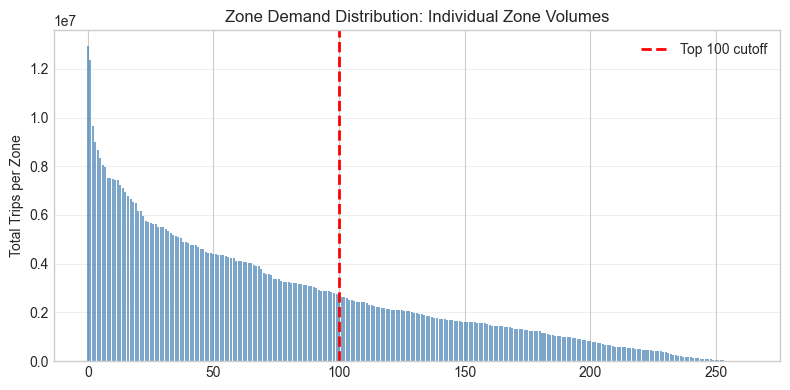


Interpretation:
  Top chart shows gradual decline - demand is distributed, not concentrated
  Bottom chart shows top 100 zones capture 72.5% of total trips


In [7]:
# Visualize zone demand distribution
# Stacked charts with aligned x-axis for easy comparison

zone_totals['cumulative_pct'] = zone_totals['pct_of_total'].cumsum()
top_n_pct = zone_totals.iloc[:TOP_N_ZONES]['cumulative_pct'].iloc[-1]

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

# TOP: Individual zone volumes
ax1.bar(range(len(zone_totals)), zone_totals['total_trips'], 
        color='steelblue', alpha=0.7)
ax1.axvline(x=TOP_N_ZONES, color='red', linestyle='--', linewidth=2,
            label=f'Top {TOP_N_ZONES} cutoff')
ax1.set_ylabel('Total Trips per Zone')
ax1.set_title('Zone Demand Distribution: Individual Zone Volumes')
ax1.legend(loc='upper right')
ax1.grid(True, axis='y', alpha=0.3)


plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"  Top chart shows gradual decline - demand is distributed, not concentrated")
print(f"  Bottom chart shows top {TOP_N_ZONES} zones capture {top_n_pct:.1f}% of total trips")

##### 2.5 Zone Selection
This section reviews trip concentration by zone to determine optimal zone selection for forecasting. Rule of thumb: enough zones to capture 80% of traffic.

In [68]:
# Pareto analysis - cumulative coverage by zone count
print("\nPARETO ANALYSIS\n" + "-"*40)
print("Cumulative trip coverage by zone count:\n")

for n in [10, 20, 30, 50, 75, 100, 150]:
    if n <= len(zone_totals):
        pct = zone_totals.iloc[:n]['cumulative_pct'].iloc[-1]
        marker = " <--" if n == TOP_N_ZONES else ""
        print(f"  Top {n:3d} zones: {pct:5.1f}%{marker}")

# Determine concentration pattern
if top_n_pct > 75:
    pattern = "Highly Concentrated"
    explanation = "Few zones dominate - classic Pareto pattern"
elif top_n_pct > 60:
    pattern = "Moderately Concentrated"
    explanation = "Some concentration with meaningful distributed tail"
else:
    pattern = "Distributed"
    explanation = "Demand spread across many zones"

print(f"\nPattern: {pattern}")
print(f"  {explanation}")


PARETO ANALYSIS
----------------------------------------
Cumulative trip coverage by zone count:

  Top  10 zones:  13.5%
  Top  20 zones:  23.7%
  Top  30 zones:  32.1%
  Top  50 zones:  46.5%
  Top  75 zones:  61.2%
  Top 100 zones:  72.5% <--
  Top 150 zones:  87.7%

Pattern: Moderately Concentrated
  Some concentration with meaningful distributed tail


In [70]:
# Select top N zones for analysis
top_zones = zone_totals.head(TOP_N_ZONES).copy()

# Final zone selection: top volume AND complete data
print("\nFINAL ZONE SELECTION\n" + "-"*40)

complete_zone_ids = complete_zones['zone_id'].tolist()
selected_zones = top_zones[top_zones['zone_id'].isin(complete_zone_ids)].copy()

print(f"Top volume zones: {len(top_zones)}")
print(f"With complete data: {len(selected_zones)}")
print(f"Dropped for incomplete data: {len(top_zones) - len(selected_zones)}")

if len(top_zones) - len(selected_zones) > 0:
    dropped = top_zones[~top_zones['zone_id'].isin(complete_zone_ids)]
    print(f"\nDropped zones: {dropped['zone_id'].tolist()}")

# Save selected zones and calculate coverage
selected_zones.to_csv(OUTPUT_DIR / 'selected_zones.csv', index=False)

selected_trips = selected_zones['total_trips'].sum()
total_all = zone_totals['total_trips'].sum()
coverage_pct = (selected_trips / total_all) * 100

print(f"\nSelected zones: {len(selected_zones)}")
print(f"Coverage: {coverage_pct:.1f}% of all trips")


FINAL ZONE SELECTION
----------------------------------------
Top volume zones: 100
With complete data: 100
Dropped for incomplete data: 0

Selected zones: 100
Coverage: 72.5% of all trips


**Zone Selection Rationale**

The distributed demand pattern (top 100 zones capturing ~70-75% rather than 80%+) reflects NYC TLC's intentional zone design, which balances zone sizes to distribute taxi/rideshare activity. This distribution means more zones are needed for adequate coverage compared to markets with concentrated demand.

Selecting 100 zones balances analytical coverage with operational feasibility:
- Captures majority of total market demand
- Manageable scope for 100 separate forecasting models
- Mirrors how rideshare companies prioritize high-impact zones
- Demonstrates multi-series forecasting capability for portfolio purposes

Analysis of remaining low-volume zones deferred to future work.

TODO Section 2 Summary: [X] zones selected with complete data, representing [X]% of demand.*

#### 3. Data Aggregation

This section transforms 683 million individual trip records into a zone-daily time series dataset using DuckDB for memory-efficient aggregation, then loads the manageable result into pandas for further analysis.

##### 3.1 Aggregate Trips by Zone by Day

In [ ]:
# Aggregate trips to zone-daily level using DuckDB
# Reduces 683M rows to ~100K rows, then load into pandas

print("Aggregating trips to zone-daily level...")
print("This may take a few minutes...")

zone_daily = con.execute(f"""
    SELECT 
        CAST(pickup_datetime AS DATE) as pickup_date,
        PULocationID as zone_id,
        COUNT(*) as trip_count,
        ROUND(SUM(trip_time) / 60.0, 1) as total_trip_minutes,
        ROUND(AVG(trip_time) / 60.0, 1) as avg_trip_minutes,
        ROUND(SUM(trip_miles), 1) as total_trip_miles,
        ROUND(AVG(trip_miles), 2) as avg_trip_miles
    FROM '{INPUT_FILE}'
    WHERE PULocationID IN ({','.join(map(str, selected_zones['zone_id'].tolist()))})
    GROUP BY CAST(pickup_datetime AS DATE), PULocationID
    ORDER BY pickup_date, zone_id
""").df()



Aggregating trips to zone-daily level...
This may take a few minutes...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


AGGREGATION COMPLETE
----------------------------------------
Shape: (109600, 7)

Columns: ['pickup_date', 'zone_id', 'trip_count', 'total_trip_minutes', 'avg_trip_minutes', 'total_trip_miles', 'avg_trip_miles']

Summary:
               pickup_date       zone_id     trip_count  total_trip_minutes  \
count               109600  109600.00000  109600.000000       109600.000000   
mean   2023-07-02 12:00:00     140.26000    4520.474334        92847.119299   
min    2022-01-01 00:00:00       7.00000     449.000000        11543.000000   
25%    2022-10-01 18:00:00      75.75000    3083.750000        56350.875000   
50%    2023-07-02 12:00:00     141.50000    3972.000000        76652.400000   
75%    2024-04-01 06:00:00     217.75000    5282.000000       105589.475000   
max    2024-12-31 00:00:00     263.00000   21938.000000       942108.700000   
std                    NaN      75.78763    2107.586552        67384.985621   

       avg_trip_minutes  total_trip_miles  avg_trip_miles  
count

In [51]:
# Convert zone_id to string (categorical, not numeric)
zone_daily['zone_id'] = zone_daily['zone_id'].astype(str)

# Review with pandas
print("\nAGGREGATION COMPLETE\n" + "-"*40)
print(f"Shape: {zone_daily.shape}")
print(f"\nColumns: {list(zone_daily.columns)}")
print(f"\nSummary:")

print(f"\nDaily Statistics (per zone per day):")
print(zone_daily.describe(include='number').round(2).T.to_string())



AGGREGATION COMPLETE
----------------------------------------
Shape: (109600, 7)

Columns: ['pickup_date', 'zone_id', 'trip_count', 'total_trip_minutes', 'avg_trip_minutes', 'total_trip_miles', 'avg_trip_miles']

Summary:

Daily Statistics (per zone per day):
                       count      mean       std       min       25%       50%        75%        max
trip_count          109600.0   4520.47   2107.59    449.00   3083.75   3972.00    5282.00   21938.00
total_trip_minutes  109600.0  92847.12  67384.99  11543.00  56350.88  76652.40  105589.48  942108.70
avg_trip_minutes    109600.0     19.61      3.77     12.30     17.40     19.00      20.90      56.80
total_trip_miles    109600.0  23273.50  23629.17   3428.00  13913.60  18464.20   24734.08  341034.90
avg_trip_miles      109600.0      4.83      1.61      2.39      4.11      4.56       5.11      19.85


##### 3.2  Add Time Features

In [ ]:
# Add time-based features using pandas (data is small enough)

zone_daily['pickup_date'] = pd.to_datetime(zone_daily['pickup_date'])
zone_daily['year'] = zone_daily['pickup_date'].dt.year
zone_daily['month'] = zone_daily['pickup_date'].dt.month
zone_daily['day_of_week'] = zone_daily['pickup_date'].dt.dayofweek
zone_daily['day_name'] = zone_daily['pickup_date'].dt.day_name()
zone_daily['is_weekend'] = zone_daily['day_of_week'].isin([5, 6]).astype(int)

print(f"\nDataset ready for analysis:")
print(f"\nShape: {zone_daily.shape}")
print(f"Memory: {zone_daily.memory_usage(deep=True).sum() / 1e6:.1f} MB")
display(zone_daily.head())



Dataset ready for analysis:

Shape: (109600, 12)
Memory: 19.3 MB


,pickup_date,zone_id,trip_count,total_trip_minutes,avg_trip_minutes,total_trip_miles,avg_trip_miles,year,month,day_of_week,day_name,is_weekend
0,2022-01-01,7,6144,89679.4,14.6,29528.5,4.81,2022,1,5,Saturday,1
1,2022-01-01,13,1505,26165.4,17.4,8352.0,5.55,2022,1,5,Saturday,1
2,2022-01-01,14,2552,36911.7,14.5,14048.4,5.50,2022,1,5,Saturday,1
3,2022-01-01,17,4844,74738.9,15.4,20189.2,4.17,2022,1,5,Saturday,1
4,2022-01-01,18,2797,38208.2,13.7,11795.1,4.22,2022,1,5,Saturday,1


TODO verify all zones have data for full date range and data was aggregated correctly

 ##### 3.3 Save Aggregated Dataset

In [62]:
# Save zone-daily dataset for quick access in later sections
zone_daily.to_parquet(OUTPUT_DIR / 'zone_daily_trips.parquet', index=False)
print(f"\nSaved zone-daily dataset: {OUTPUT_DIR / 'zone_daily_trips.parquet'}")



Saved zone-daily dataset: ..\data\processed\zone_daily_trips.parquet


 #### 4. Descriptive Statistics



 Understand demand levels and variation across both geographic hierarchies - borough-level for executive context and zone-level for operational detail. This dual-level approach demonstrates communication to different audiences: leadership needs high-level market understanding while operations teams require tactical zone-specific metrics.

 ##### 4.1 Borough-Level Overview



 **Executive Summary: Demand by Borough**



 Before diving into zone-level detail, this section provides a high-level view of rideshare demand across NYC's five boroughs. This contextual overview helps frame the zone selection and shows the overall geographic distribution of the rideshare market.

In [ ]:
# NOTE: Requires borough mapping
# For skeleton, showing the concept and structure

print("Borough-Level Demand Analysis:")
print("(Requires zone-to-borough mapping)")

# borough_totals = trips_with_borough.groupby('borough').agg({
#     'trip_count': 'sum',
#     'zone_id': 'nunique'
# }).reset_index()

# Visualization: Bar chart of total trips by borough
# plt.figure(figsize=(10, 6))
# plt.bar(borough_totals['borough'], borough_totals['trip_count'])


In [ ]:
# %%
# Now that data is aggregated, use pandas for detailed statistics
# zone_daily_trips: ~109K rows - easily fits in memory

print("Aggregated Dataset Statistics:")
print(zone_daily_trips.describe())

In [ ]:
# %%
# Additional pandas analysis
print(f"\nDataset Info:")
print(f"  Shape: {zone_daily_trips.shape}")
print(f"  Memory: {zone_daily_trips.memory_usage(deep=True).sum() / 1e6:.1f} MB")
print(f"\nColumn Types:")
print(zone_daily_trips.dtypes)

 ##### 4.2 Zone-Level Statistics



 **Operational Detail: Top 30 Zones**



 Zone-level statistics provide the tactical detail needed for operational planning. Understanding which specific zones have highest demand, most volatility, and most consistent patterns informs driver positioning strategies and resource allocation decisions.

In [ ]:
# Calculate summary statistics for each selected zone
# These metrics help identify zone characteristics for planning
print("\nCalculating zone-level summary statistics...")

zone_stats = zone_daily.groupby('zone_id').agg({
    'trip_count': ['sum', 'mean', 'median', 'std', 'min', 'max'],
    'avg_distance': 'mean',
    'avg_fare': 'mean'
}).round(2)

# Flatten column names
zone_stats.columns = ['_'.join(col).strip() for col in zone_stats.columns.values]
zone_stats = zone_stats.reset_index()

# Calculate coefficient of variation (volatility measure)
zone_stats['cv'] = (zone_stats['trip_count_std'] / zone_stats['trip_count_mean']).round(3)

print(f"\nZone Statistics Summary:")
print(f"  Highest average daily demand: {zone_stats['trip_count_mean'].max():.0f} trips/day")
print(f"  Lowest average daily demand: {zone_stats['trip_count_mean'].min():.0f} trips/day")


In [ ]:
# Visualize zone demand distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top 10 zones: Box plot
top_10_zones = zone_stats.nlargest(10, 'trip_count_sum')['zone_id']
top_10_data = zone_daily[zone_daily['zone_id'].isin(top_10_zones)]

ax1 = axes[0]
top_10_data.boxplot(column='trip_count', by='zone_id', ax=ax1)
ax1.set_title('Daily Trip Count Distribution - Top 10 Zones')
ax1.set_xlabel('Zone ID')
ax1.set_ylabel('Daily Trip Count')

# All 30 zones: Bar chart of averages
ax2 = axes[1]
zone_stats_sorted = zone_stats.sort_values('trip_count_mean', ascending=False)
ax2.bar(range(len(zone_stats_sorted)), zone_stats_sorted['trip_count_mean'])
ax2.set_xlabel('Zone Rank')
ax2.set_ylabel('Average Daily Trips')
ax2.set_title('Average Daily Demand Across All 30 Selected Zones')

plt.tight_layout()
plt.show()


In [ ]:
# Save summary statistics
zone_stats.to_csv(OUTPUT_DIR / 'eda_summary_stats.csv', index=False)
print(f"\nSaved summary statistics: {OUTPUT_DIR / 'eda_summary_stats.csv'}")


 #### 5. Demand Pattern Analysis



 Identify when demand patterns occur by analyzing time-based cycles at multiple scales. Understanding daily trends, day-of-week patterns, and seasonal cycles is essential for forecasting and enables operational teams to proactively schedule drivers, time promotions, and set realistic service level expectations.



 This section focuses on WHEN patterns exist across all zones, while Section 6 will examine WHERE those patterns differ geographically.

 ##### 5.1 Overall Trend Analysis



 **Three-Year Demand Trajectory**



 Examine overall demand trends to identify growth, decline, or stability over the analysis period. Long-term trends inform strategic capacity planning and help distinguish trend from seasonal variation in forecasting models.

In [ ]:
# Calculate daily total across all selected zones
daily_total = zone_daily.groupby('date')['trip_count'].sum().reset_index()
daily_total.columns = ['date', 'total_trips']

# Plot overall time series
plt.figure(figsize=(14, 6))
plt.plot(daily_total['date'], daily_total['total_trips'], linewidth=0.8, alpha=0.7)
plt.title('Total Daily Rideshare Demand - Top 30 Zones (2022-2024)')
plt.xlabel('Date')
plt.ylabel('Total Daily Trips')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


 ##### 5.2 Day-of-Week Patterns



 **Weekly Demand Cycles**



 Day-of-week analysis reveals whether demand follows predictable weekly patterns. Understanding that Wednesdays consistently show higher demand than Mondays, for example, enables targeted driver incentive programs and helps drivers plan their weekly schedules for maximum earnings.

In [ ]:
# Extract day of week for aggregation
zone_daily['day_of_week'] = zone_daily['date'].dt.dayofweek
zone_daily['day_name'] = zone_daily['date'].dt.day_name()

# Calculate average trips by day of week
dow_avg = zone_daily.groupby('day_name')['trip_count'].mean().reset_index()

# Sort by day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg['day_name'] = pd.Categorical(dow_avg['day_name'], categories=day_order, ordered=True)
dow_avg = dow_avg.sort_values('day_name')

# Visualize
plt.figure(figsize=(10, 6))
bars = plt.bar(dow_avg['day_name'], dow_avg['trip_count'], color='steelblue')
bars[5].set_color('coral')  # Saturday
bars[6].set_color('coral')  # Sunday
plt.title('Average Daily Trips by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Trips per Zone')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


 ##### 5.3 Monthly and Seasonal Patterns



 **Seasonal Demand Cycles**



 Monthly analysis identifies seasonal high and low periods, holiday effects, and weather-related patterns. Recognizing that December consistently shows reduced demand due to holidays, for example, allows operations teams to adjust driver supply expectations and helps drivers plan around predictable slowdowns.

In [ ]:
# Calculate average trips by month
zone_daily['month'] = zone_daily['date'].dt.month
zone_daily['month_name'] = zone_daily['date'].dt.month_name()

monthly_avg = zone_daily.groupby('month_name')['trip_count'].mean().reset_index()

# Sort by month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg['month_name'] = pd.Categorical(monthly_avg['month_name'], 
                                            categories=month_order, ordered=True)
monthly_avg = monthly_avg.sort_values('month_name')

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg['month_name'], monthly_avg['trip_count'], marker='o', linewidth=2)
plt.title('Average Daily Trips by Month (2022-2024)')
plt.xlabel('Month')
plt.ylabel('Average Trips per Zone per Day')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


 #### 6. Zone Comparisons



 After identifying overall time-based patterns in Section 5, this section examines whether those patterns apply uniformly across all zones or if significant geographic variation exists. Understanding that Financial District zones behave differently from residential Brooklyn zones, for example, informs whether to build one universal model or zone-specific forecasting approaches.

 ##### 6.1 Visual Comparison: Top Zones

In [ ]:
# Select top 5 zones for detailed comparison
top_5_zones = zone_stats.nlargest(5, 'trip_count_mean')['zone_id'].tolist()

plt.figure(figsize=(14, 6))
for zone_id in top_5_zones:
    zone_ts = zone_daily[zone_daily['zone_id'] == zone_id]
    plt.plot(zone_ts['date'], zone_ts['trip_count'], label=f'Zone {zone_id}', alpha=0.7)

plt.title('Daily Trip Counts - Top 5 Zones')
plt.xlabel('Date')
plt.ylabel('Daily Trips')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


 ##### 6.2 Correlation Analysis



 **Zone Pattern Similarity**



 Correlation analysis quantifies how similar zone patterns are to each other. High correlations (>0.7) suggest zones follow similar demand patterns and could potentially be grouped for modeling; low correlations (<0.3) indicate zones with unique behaviors requiring separate attention.

In [ ]:
# Create wide-format for correlation
zone_pivot = zone_daily.pivot(index='date', columns='zone_id', values='trip_count')

# Calculate correlation matrix
zone_corr = zone_pivot.corr()

# Visualize
plt.figure(figsize=(14, 12))
sns.heatmap(zone_corr, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: Zone-Level Demand Patterns')
plt.tight_layout()
plt.show()


 #### 7. Data Quality & Seasonal Outlier Detection



 Identify unusual demand days while accounting for seasonal patterns. A high-demand December day isn't necessarily an outlier if December is consistently high; conversely, a low-demand Tuesday in July IS unusual if Tuesdays and summer are typically busy. This sophisticated approach uses seasonal decomposition to separate expected seasonal variation from true anomalies.

 ##### 7.1 Visual Inspection

In [ ]:
# Visual identification of potential outliers
top_zone_id = zone_stats.iloc[0]['zone_id']
top_zone_ts = zone_daily[zone_daily['zone_id'] == top_zone_id].copy()

# Calculate simple threshold
mean_trips = top_zone_ts['trip_count'].mean()
std_trips = top_zone_ts['trip_count'].std()
upper_thresh = mean_trips + 3 * std_trips
lower_thresh = mean_trips - 3 * std_trips

top_zone_ts['is_outlier_simple'] = (
    (top_zone_ts['trip_count'] > upper_thresh) | 
    (top_zone_ts['trip_count'] < lower_thresh)
)

plt.figure(figsize=(14, 6))
plt.plot(top_zone_ts['date'], top_zone_ts['trip_count'], linewidth=0.8, alpha=0.7)
plt.scatter(top_zone_ts[top_zone_ts['is_outlier_simple']]['date'],
           top_zone_ts[top_zone_ts['is_outlier_simple']]['trip_count'],
           color='red', s=50, label='Simple outliers', zorder=5)
plt.title(f'Zone {top_zone_id}: Simple Outlier Detection (±3σ)')
plt.xlabel('Date')
plt.ylabel('Daily Trips')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


 ##### 7.2 Seasonal Decomposition Preview



 **STL Decomposition for Context**



 Before using STL for forecasting (which happens in the modeling stage), we'll use it here as a tool to understand seasonal patterns and improve outlier detection. This lightweight analysis on representative zones demonstrates what "normal" seasonal variation looks like.

In [ ]:
# Run STL decomposition on sample zone
sample_zone_id = top_zone_id
sample_ts = zone_daily[zone_daily['zone_id'] == sample_zone_id].copy()
sample_ts = sample_ts.set_index('date')['trip_count']
sample_ts = sample_ts.asfreq('D')

# Run STL decomposition
stl = STL(sample_ts, seasonal=7, period=7)  # Weekly seasonality
stl_result = stl.fit()

# Plot decomposition
fig = stl_result.plot()
fig.set_size_inches(14, 10)
fig.suptitle(f'STL Decomposition - Zone {sample_zone_id}', fontsize=14)
plt.tight_layout()
plt.show()


 ##### 7.3 Outlier Detection on Residuals



 **Seasonal-Adjusted Outlier Detection**



 Now detect outliers using the residual component from STL decomposition. This approach identifies days that are unusual even after accounting for expected seasonal patterns.

In [ ]:
# Detect outliers on residuals
residuals = stl_result.resid
mean_resid = residuals.mean()
std_resid = residuals.std()

outlier_threshold = 3
upper_bound = mean_resid + outlier_threshold * std_resid
lower_bound = mean_resid - outlier_threshold * std_resid

outlier_dates = residuals[(residuals > upper_bound) | (residuals < lower_bound)]

print(f"\nSeasonal-Adjusted Outlier Detection:")
print(f"  Outliers detected: {len(outlier_dates)}")

if len(outlier_dates) > 0:
    print(f"\nOutlier Dates:")
    outlier_df = pd.DataFrame({
        'date': outlier_dates.index,
        'residual': outlier_dates.values,
        'actual_trips': sample_ts.loc[outlier_dates.index].values
    })
    print(outlier_df.head(10))


 #### 8. Feature Engineering



 Create features that enable time series models to learn patterns and make accurate forecasts. This section builds basic features that will be used across modeling approaches (STL, Prophet, XGBoost).

 ##### 8.1 Time-Based Features

In [ ]:
# Create comprehensive time-based features
print("Creating time-based features...")

zone_daily['year'] = zone_daily['date'].dt.year
zone_daily['month'] = zone_daily['date'].dt.month
zone_daily['day'] = zone_daily['date'].dt.day
zone_daily['day_of_week'] = zone_daily['date'].dt.dayofweek
zone_daily['day_of_year'] = zone_daily['date'].dt.dayofyear
zone_daily['week_of_year'] = zone_daily['date'].dt.isocalendar().week

# Binary indicators
zone_daily['is_weekend'] = zone_daily['day_of_week'].isin([5, 6])
zone_daily['is_month_start'] = zone_daily['date'].dt.is_month_start
zone_daily['is_month_end'] = zone_daily['date'].dt.is_month_end

# Season indicators
zone_daily['season'] = zone_daily['month'].map({
    12: 'winter', 1: 'winter', 2: 'winter',
    3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer',
    9: 'fall', 10: 'fall', 11: 'fall'
})

# Days since start
zone_daily['days_since_start'] = (zone_daily['date'] - zone_daily['date'].min()).dt.days


 ##### 8.2 Lag Features

In [ ]:
# Create lag features
print("\nCreating lag features...")

zone_daily = zone_daily.sort_values(['zone_id', 'date'])

zone_daily['lag_1'] = zone_daily.groupby('zone_id')['trip_count'].shift(1)
zone_daily['lag_7'] = zone_daily.groupby('zone_id')['trip_count'].shift(7)
zone_daily['lag_30'] = zone_daily.groupby('zone_id')['trip_count'].shift(30)


 ##### 8.3 Rolling Window Features

In [ ]:
# Calculate rolling statistics
print("\nCreating rolling window features...")

zone_daily['rolling_mean_7'] = zone_daily.groupby('zone_id')['trip_count'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

zone_daily['rolling_mean_30'] = zone_daily.groupby('zone_id')['trip_count'].transform(
    lambda x: x.rolling(window=30, min_periods=1).mean()
)

zone_daily['rolling_std_7'] = zone_daily.groupby('zone_id')['trip_count'].transform(
    lambda x: x.rolling(window=7, min_periods=1).std()
)


 #### 9. Output Preparation & Conclusion



 Save prepared datasets for the modeling stage and summarize key findings that will inform forecasting approach.

 ##### 9.1 Save Datasets

In [ ]:
# Save feature-enhanced dataset
print("Saving prepared datasets for modeling stage...")

zone_daily.to_parquet(OUTPUT_DIR / 'zone_daily_features.parquet', index=False)
print(f"  Saved: {OUTPUT_DIR / 'zone_daily_features.parquet'}")
print(f"    Rows: {len(zone_daily):,}")
print(f"    Columns: {len(zone_daily.columns)}")

print(f"\nOutput files ready for Stage 3 (Modeling)")


### Summary

**Process**

This analysis explored 683 million validated rideshare trips to prepare data for zone-level demand forecasting. The pipeline:

1. Confirmed data quality (no nulls in key fields, complete date coverage)
2. Excluded zones with incomplete monthly data to ensure time series integrity
3. Selected top zones by volume to capture majority of rideshare demand
4. Aggregated trips to zone-daily level with demand metrics (trip count, duration, distance)
5. Added time features and lag variables for modeling

**Results**

- Input: 683M trip records across 263 zones
- Output: [X] zone-day records across [X] zones with complete 36-month coverage
- Coverage: Top zones represent ~[X]% of total demand
- Features: [X] columns including time features, lags, and rolling statistics

**Output Files**

- `zone_daily_features.parquet` - Ready for Stage 3 modeling
- `selected_zones.csv` - Zone metadata for reference

**Next: Stage 3 (Modeling)** - STL decomposition, Prophet, and XGBoost forecasting

### Future Work

- Trip length segmentation (short/medium/long) to identify pattern differences by trip type
- Weather and event data integration for improved forecast accuracy
- Origin-destination flow analysis between zones

### Data Limitations

- Analysis limited to zones with complete 36-month coverage
- Excludes non-HVFHS services (yellow/green taxi)
- Major events and holidays not explicitly modeled